In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.extend(['.', '..'])

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.legend_handler import HandlerPatch
import matplotlib.gridspec as gridspec
plt.style.use('./paper.mplstyle')

from scipy import interpolate

import ternary

from utils import fr as fr_utils
from utils import misc as misc_utils
from utils.enums import MixingScenario

In [3]:
s = [1, 0, 0]
print s, '->', fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))
s = [0, 1, 0]
print s, '->', fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))
s = [1, 2, 0]
print s, '->', fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))

[1, 0, 0] -> [0.55003613 0.18301213 0.26695174]
[0, 1, 0] -> [0.18301213 0.43765598 0.37933189]
[1, 2, 0] -> [0.30535346 0.3527747  0.34187184]


In [4]:
SM_120 = np.load('./chains/mcmc_unitary_DIM3_sfr_1_2_0_mfr_5.50076E+15_6.35502E+15_6.15862E+15_fix_scale_0.1_sigma_10000000_proc.npy')

T13_010 = np.genfromtxt('./frs/fr_DIM6_sfr_0_1_0_mfr_1_1_1_MixingScenario.T13_flat.txt')
T23_100 = np.genfromtxt('./frs/fr_DIM6_sfr_1_0_0_mfr_1_1_1_MixingScenario.T23_flat.txt')
#T13_010 = np.genfromtxt('./frs/fr_DIM4_sfr_0_1_0_mfr_1_1_1_MixingScenario.T13_flat.txt')
#T23_100 = np.genfromtxt('./frs/fr_DIM4_sfr_1_0_0_mfr_1_1_1_MixingScenario.T23_flat.txt')

In [5]:
print SM_120.shape, T13_010.shape, T23_100.shape

(200000, 3) (6942, 4) (7059, 4)


In [6]:
bc = np.genfromtxt('./bayes_contours.csv', delimiter=',', skip_header=2)
print bc

def swap(x):
    y = x.T
    return np.vstack([y[1], y[-1], y[0]]).T

def interp(i):
    x, y, z = i.T
    p = np.linspace(0, 1, len(x))
    q = np.linspace(0, 1, 100)
    s = 0.2
    x_ = interpolate.splev(q, interpolate.splrep(p, x, s=s))
    y_ = interpolate.splev(q, interpolate.splrep(p, y, s=s))
    z_ = interpolate.splev(q, interpolate.splrep(p, z, s=s))
    return np.vstack([x_, y_, z_]).T

contour_68_upper = interp(swap(bc[:,:3]))
contour_68_lower = interp(swap(bc[:,3:6]))
contour_90_upper = interp(swap(bc[:,6:9]))
contour_90_lower = interp(swap(bc[:,9:]))

[[4.24138244e-03 3.06813681e-01 6.88944937e-01 2.34316066e-03
  6.42617953e-01 3.55038887e-01 3.98424527e-03 2.38034475e-01
  7.57981280e-01 1.85873303e-03 7.47360118e-01 2.50781149e-01]
 [1.02100395e-01 2.38679390e-01 6.59220214e-01 2.26570797e-01
  4.93377801e-01 2.80051402e-01 1.09359466e-01 1.65212361e-01
  7.25428173e-01 2.35934718e-01 6.08010059e-01 1.56055223e-01]
 [2.52239502e-01 1.42289922e-01 6.05470576e-01 4.15291021e-01
  3.59870470e-01 2.24838509e-01 2.33469416e-01 8.91797869e-02
  6.77350797e-01 4.52535945e-01 4.33980928e-01 1.13483126e-01]
 [3.68351571e-01 8.26973453e-02 5.48951083e-01 5.92164115e-01
  1.97335547e-01 2.10500337e-01 3.26662769e-01 3.83846610e-02
  6.34952570e-01 6.48292082e-01 2.61042953e-01 9.06649650e-02]
 [5.16972192e-01 1.91319942e-03 4.81114609e-01 7.41232430e-01
  1.98363517e-03 2.56783935e-01 3.86792430e-01 8.82077324e-04
  6.12325493e-01 9.06104571e-01 3.59369535e-03 9.03017336e-02]]


In [7]:
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height,
                       fontsize, trans):
        r = 10
        x = r + width//2 + 10
        y = height//2 - 3

        # create 
        p = Circle(xy=(x, y), radius=r)

        # update with data from oryginal object
        self.update_prop(p, orig_handle, legend)

        # move xy to legend
        p.set_transform(trans)

        return [p]

In [8]:
d = [T13_010, T23_100]
min_scale = 1E100
max_scale = -1E100

for i in d:
    min_scale = min_scale if min_scale < np.min(i[:,-1]) else np.min(i[:,-1])
    max_scale = max_scale if max_scale > np.max(i[:,-1]) else np.max(i[:,-1])

print 'min_scale', min_scale
print 'max_scale', max_scale

min_scale -42.0
max_scale -30.0


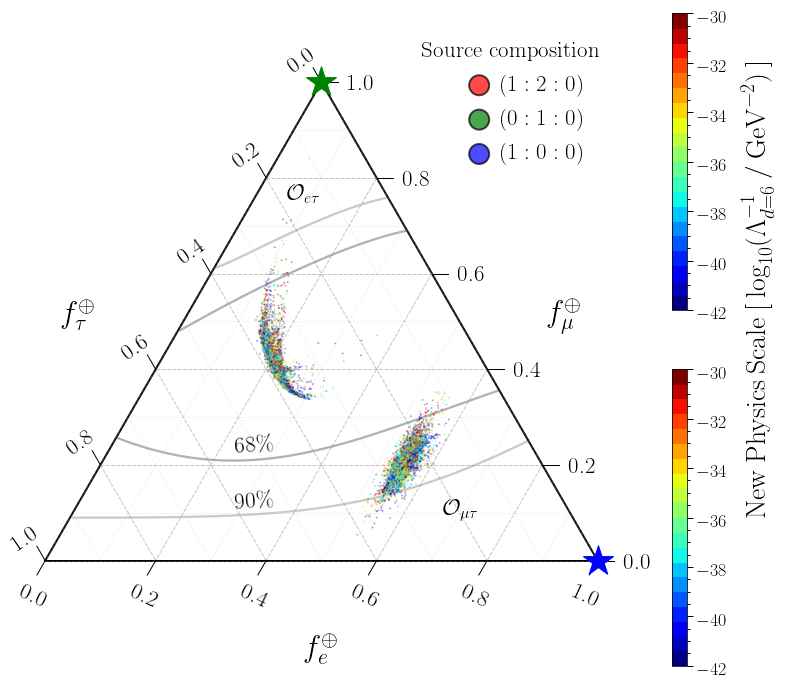

In [9]:
# Figure
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[40, 1])
gs.update(hspace=0.4, wspace=0.15)

ax = fig.add_subplot(gs[0])
ax.set_aspect('equal')

norm = mpl.colors.Normalize(vmin=min_scale, vmax=max_scale)

# Boundary and Gridlines
scale = 1
fig, tax = ternary.figure(ax=ax, scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color='grey', multiple=scale/5., linewidth=1.0, alpha=0.4, ls='--')
tax.gridlines(color='grey', multiple=scale/10., linewidth=0.5, alpha=0.4, ls=':')

# Set Axis labels and Title
fontsize = 23
tax.left_axis_label(r"$f_{\tau}^{\oplus}$", fontsize=fontsize+8, offset=0.2, rotation=0)
tax.right_axis_label(r"$f_{\mu}^{\oplus}$", fontsize=fontsize+8, offset=0.2, rotation=0)
tax.bottom_axis_label(r"$f_{e}^{\oplus}$", fontsize=fontsize+8, position=(0.55, -0.20/2, 0.5), rotation=0)

# Remove default Matplotlib axis
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()

# Plot
#tax.scatter(SM_120, marker='.', s=0.8, alpha=0.2, color='red')
tax.scatter([[0, 1, 0]], marker='*', s=1000, alpha=1.0, color='green', zorder=100)
tax.scatter([[1, 0, 0]], marker='*', s=1000, alpha=1.0, color='blue', zorder=100)

# Contour
tax.plot(contour_68_upper, linewidth=2.3, color='grey', zorder=0, alpha=0.6)
tax.plot(contour_68_lower, linewidth=2.3, color='grey', zorder=0, alpha=0.6)
tax.plot(contour_90_upper, linewidth=2.3, color='darkgrey', zorder=0, alpha=0.6)
tax.plot(contour_90_lower, linewidth=2.3, color='darkgrey', zorder=0, alpha=0.6)

# Lines
marker_style = dict(
    linestyle=' ', color='darkorange', linewidth=1.2,
    markersize=14, zorder=0
)

# Trajectories
cmap_010 = plt.get_cmap('jet', 20)
cmap_100 = plt.get_cmap('jet', 20)

def alp(x):
    y = list(x)
    y[-1] = 0.3
    return y

tax.scatter(T13_010[:,:-1], marker='o', s=1, color=map(alp, map(cmap_010, map(norm, T13_010[:,-1]))))
tax.scatter(T23_100[:,:-1], marker='o', s=1, color=map(alp, map(cmap_100, map(norm, T23_100[:,-1]))))

# Text
#ax.text(0.63, 0.46, r'$\mathcal{O}_{e\mu}$', fontsize=fontsize,
#       rotation=0, verticalalignment='center')
ax.text(0.437, 0.66, r'$\mathcal{O}_{e\tau}$', fontsize=fontsize,
       rotation=0, verticalalignment='center')
ax.text(0.72, 0.09, r'$\mathcal{O}_{\mu\tau}$', fontsize=fontsize,
       rotation=0, verticalalignment='center')
ax.text(0.34, 0.2, r'$68\%$', fontsize=fontsize, rotation=5)
ax.text(0.34, 0.1, r'$90\%$', fontsize=fontsize, rotation=5)

# Legend
l_size = fontsize
legend_elements = []
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='red', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (1:2:0\right )$')
)
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='green', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (0:1:0\right )$')
)
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='blue', alpha=0.7, edgecolor='k',
           linewidth=2., label=r'$\left (1:0:0\right )$')
)
legend = plt.legend(handles=legend_elements, loc=(0.65, 0.8),
                    title='Source composition',
                    fontsize=l_size,
                    handler_map={Circle: HandlerCircle()})
plt.setp(legend.get_title(), fontsize=l_size)
legend.get_frame().set_linestyle('-')

# Colorbar
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1])
ax0 = fig.add_subplot(gs00[0])
cb = mpl.colorbar.ColorbarBase(ax0, cmap=cmap_010, norm=norm)
cb.ax.tick_params(labelsize=fontsize-5)
ax1 = fig.add_subplot(gs00[1])
cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap_100, norm=norm)
cb.ax.tick_params(labelsize=fontsize-5)
cb.set_label(r'${\rm New\:Physics\:Scale}\:[\:{\rm log}_{10} (\Lambda^{-1}_{d=6}\:/\:{\rm GeV}^{-2})\: ]$',
            fontsize=fontsize+5, labelpad=20, horizontalalignment='left')

# Set ticks
tax.ticks(axis='blr', multiple=scale/5., linewidth=1, offset=0.03,
          fontsize=fontsize, tick_formats='%.1f')

tax._redraw_labels()

# save
fig.savefig('./plots/fr_trajectory.png', bbox_inches='tight', dpi=150)